# Load Datasets

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

+ X_label IMG

In [2]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [3]:
d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/img.csv')
img_dataset = img_dataset_cache.copy()

In [4]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
        
img_arr = img_arr/255.0

In [5]:
img_arr.shape

(1205, 150, 150, 3)

fac

In [34]:
pre_facial = pd.read_csv('./dataset/facial.csv')

if 'Unnamed: 0' in pre_facial.columns:
    pre_facial = pre_facial.drop('Unnamed: 0', axis=1)

In [35]:
imsi = pre_facial.copy()

# categorical data to one-hot
fac_input_df = pd.get_dummies(imsi, prefix=['gender', 'dominant_race'])

# Normalization
fac_input_norm = (fac_input_df - fac_input_df.mean()) / fac_input_df.std()

fac_input = np.array(fac_input_norm)

clr


In [36]:
clr_data = pd.read_csv('./dataset/clr.csv')
if 'Unnamed: 0' in clr_data.columns:
    clr_data = clr_data.drop('Unnamed: 0', axis=1)

In [37]:
clr_input = np.array( (clr_data - clr_data.mean())/clr_data.std() )

In [38]:
faclr = np.concatenate((clr_input,fac_input_df), axis=1)

+ y_label

In [6]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

In [7]:
y_out.shape

(1205, 11)

In [111]:
# y_data = pd.read_csv('./dataset/y_label.csv')

# y_out = np.array(y_data)

# img_arr = img_arr.astype('float64')

-----

In [8]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=123)
# input3_s = sklearn.utils.shuffle(xinput,random_state=123)
y_out_s = sklearn.utils.shuffle(y_out, random_state=123)
# n = sklearn.utils.shuffle(n, random_state=123)


img_arr_test = img_arr_s[1100:]
# input3_test = input3_s[1100:]
y_out_test = y_out_s[1100:]
# n_test = n[1100:]

X_train = img_arr_s[:1100]
# input3_train = input3_s[:1100]
y_train = y_out_s[:1100]
# n_train = n[:1100]

---

# ResNet Modeling w/ BP-MLL

Make Model using keras functional api

However, act.func. of last layer is not 'softmax' but 'sigmoid'

In [39]:
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense, Flatten, BatchNormalization, AveragePooling2D
from keras.layers import Concatenate
#from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
#from keras.optimizers import RMSprop
from keras.datasets import cifar10
import keras.backend as K

In [40]:
NUM_CLASSES = 11

In [41]:
from tensorflow.keras.layers import Concatenate, MaxPooling2D, Conv2D, BatchNormalization, Activation

def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, (kernel_size[0], kernel_size[1]), padding=padding, strides=strides)(x)    
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

def inception_f3(input_tensor, filter_channels, name=None):
    filter_b1, filter_b2, filter_b3, filter_b4 = filter_channels
    
    branch_1 = conv2d_bn(input_tensor, filter_b1[0], (1, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[1], (3, 3))
    branch_1 = conv2d_bn(branch_1, filter_b1[2], (3, 3))
    
    branch_2 = conv2d_bn(input_tensor, filter_b2[0], (1, 1))
    branch_2 = conv2d_bn(branch_2, filter_b2[1], (3, 3))
    
    branch_3 = MaxPooling2D((3, 3), strides=1, padding='same')(input_tensor)
    branch_3 = conv2d_bn(branch_3, filter_b3, (1, 1))
    
    branch_4 = conv2d_bn(input_tensor, filter_b4, (1, 1))
    
    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3, branch_4]) if not name==None else Concatenate()([branch_1, branch_2, branch_3, branch_4])
    
    return filter_concat

def inception_f6(input_tensor, filter_channels, n=7, name=None):
    filter_b1, filter_b2, filter_b3, filter_b4 = filter_channels
    
    branch_1 = conv2d_bn(input_tensor, filter_b1[0], (1, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[1], (1, n))
    branch_1 = conv2d_bn(branch_1, filter_b1[2], (n, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[3], (1, n))
    branch_1 = conv2d_bn(branch_1, filter_b1[4], (n, 1))
    
    branch_2 = conv2d_bn(input_tensor, filter_b2[0], (1, 1))
    branch_2 = conv2d_bn(branch_2, filter_b2[1], (1, n))
    branch_2 = conv2d_bn(branch_2, filter_b2[2], (n, 1))
    
    branch_3 = MaxPooling2D((3, 3), strides=1, padding='same')(input_tensor)
    branch_3 = conv2d_bn(branch_3, filter_b3, (1, 1))
    
    branch_4 = conv2d_bn(input_tensor, filter_b4, (1, 1))
    
    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3, branch_4]) if not name==None else Concatenate()([branch_1, branch_2, branch_3, branch_4])
    
    return filter_concat

def inception_f10(input_tensor, filter_channels, name=None):
    filter_b1, filter_b2, filter_b3, filter_b4 = filter_channels
    
    branch_1 = conv2d_bn(input_tensor, filter_b1[0], (1, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[1], (3, 3))
    branch_1a = conv2d_bn(branch_1, filter_b1[2][0], (1, 3))
    branch_1b = conv2d_bn(branch_1, filter_b1[2][1], (3, 1))
    branch_1 = Concatenate()([branch_1a, branch_1b])
    
    branch_2 = conv2d_bn(input_tensor, filter_b2[0], (1, 1))
    branch_2a = conv2d_bn(branch_2, filter_b2[1][0], (1, 3))
    branch_2b = conv2d_bn(branch_2, filter_b2[1][1], (3, 1))
    branch_2 = Concatenate()([branch_2a, branch_2b])
    
    branch_3 = MaxPooling2D((3, 3), strides=1, padding='same')(input_tensor)
    branch_3 = conv2d_bn(branch_3, filter_b3, (1, 1))
    
    branch_4 = conv2d_bn(input_tensor, filter_b4, (1, 1))
    
    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3, branch_4]) if not name==None else Concatenate()([branch_1, branch_2, branch_3, branch_4])
    
    return filter_concat
    
def inception_dim_reduction(input_tensor, filter_channels, name=None):
    filter_b1, filter_b2 = filter_channels
    
    branch_1 = conv2d_bn(input_tensor, filter_b1[0], (1, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[1], (3, 3))
    branch_1 = conv2d_bn(branch_1, filter_b1[2], (3, 3), strides=2)
    
    branch_2 = conv2d_bn(input_tensor, filter_b2[0], (1, 1))
    branch_2 = conv2d_bn(branch_2, filter_b2[1], (3, 3), strides=2)
    
    branch_3 = MaxPooling2D((3, 3), strides=2, padding='same')(input_tensor)
    
    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3]) if not name==None else Concatenate()([branch_1, branch_2, branch_3])
    
    return filter_concat

In [59]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, AveragePooling2D, Flatten
from tensorflow.keras import Model

def Inception_v3(model_input):
    x = conv2d_bn(model_input, 32, (3, 3), padding='valid', strides=2) # (299, 299, 3) -> (149, 149, 32)
    x = conv2d_bn(x, 32, (3, 3), padding='valid') # (147, 147, 32) -> (147, 147, 32)
    x = conv2d_bn(x, 64, (3, 3), padding='same') # (147, 147, 32) -> (147, 147, 64)
    
    x = MaxPooling2D((3, 3), strides=2, padding='valid')(x) # (147, 147, 64) -> (73, 73, 64)
    
    x = conv2d_bn(x, 80, (3, 3), padding='valid') # (73, 73, 64) -> (71, 71, 80)
    x = conv2d_bn(x, 192, (3, 3), padding='valid', strides=2) # (71, 71, 80) -> (35, 35, 192)
    x = conv2d_bn(x, 288, (3, 3), padding='same') # (35, 35, 192) -> (35, 35, 288)
    
    x = inception_f3(x, [[64, 96, 96], [48, 64], 64 , 64]) # (35, 35, 288)
    x = inception_f3(x, [[64, 96, 96], [48, 64], 64 , 64]) # (35, 35, 288)
    x = inception_f3(x, [[64, 96, 96], [48, 64], 64 , 64], name='block_inception_f3') # (35, 35, 288)
    
    x = inception_dim_reduction(x, [[64, 96, 96], [256, 384]], name='block_reduction_1') # (35, 35, 288) -> (17, 17, 768)
    
    x = inception_f6(x, [[128, 128, 128, 128, 192], [128, 128, 192], 192, 192]) # (17, 17, 768)
    x = inception_f6(x, [[160, 160, 160, 160, 192], [160, 160, 192], 192, 192]) # (17, 17, 768)
    x = inception_f6(x, [[160, 160, 160, 160, 192], [160, 160, 192], 192, 192]) # (17, 17, 768)
    x = inception_f6(x, [[192, 192, 192, 192, 192], [192, 192, 192], 192, 192]) # (17, 17, 768)
    x_a = inception_f6(x, [[192, 192, 192, 192, 192], [192, 192, 192], 192, 192], name='block_inception_f6') # (17, 17, 768)
    
    x = inception_dim_reduction(x_a, [[128, 192, 192], [192, 320]], name='block_reduction_2') # (17, 17, 768) -> (8, 8, 1280)
    
    x = inception_f10(x, [[448, 384, [384, 384]], [384, [384, 384]], 192, 320]) # (8, 8, 1280) -> (8, 8, 2048)
    x = inception_f10(x, [[448, 384, [384, 384]], [384, [384, 384]], 192, 320], name='block_inception_f10') # (8, 8, 2048)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.8)(x)
    
    x = Dense(NUM_CLASSES, activation=None)(x)
    
    model_output = Dense(NUM_CLASSES, activation='softmax', name='main_classifier')(x) # 'softmax'
    
    # Auxiliary Classifier
    auxiliary = AveragePooling2D((5, 5), strides=3, padding='valid')(x_a) # (17, 17, 768) -> (5, 5, 768)
    auxiliary = conv2d_bn(auxiliary, 128, (1, 1)) # (5, 5, 768) -> (5, 5, 128)
    
    auxiliary = conv2d_bn(auxiliary, 1024, K.int_shape(auxiliary)[1:3], padding='valid') # (5, 5, 768) -> (1, 1, 1024)
    auxiliary = Flatten()(auxiliary) # (1, 1, 1024)
    auxiliary_output = Dense(NUM_CLASSES, activation='sigmoid', name='auxiliary_classifier')(auxiliary)
    
    model = Model(model_input, [model_output, auxiliary_output])
    
    return model

In [46]:
from keras.models import Model, Input

input_shape = (150, 150, 3) #(299,299,3)
model_input = Input( shape=input_shape )

In [60]:
model = Inception_v3(model_input)

In [ ]:
# you can see model summary

tf.keras.utils.plot_model(model, show_shapes=True)

Compiling the Model

In [53]:
smoothing_param = 0.1

def smoothed_categorical_crossentropy(y_true, y_pred): 
    if smoothing_param > 0:
        smooth_positives = 1.0 - smoothing_param 
        smooth_negatives = smoothing_param / NUM_CLASSES 
        y_true = y_true * smooth_positives + smooth_negatives 

    return K.categorical_crossentropy(y_true, y_pred)

class LearningRateSchedule(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%2 == 0:
            lr = K.get_value(self.model.optimizer.lr)
            K.set_value(self.model.optimizer.lr, lr*0.94)

In [77]:
from bpmll import bp_mll_loss
import tensorflow as tf
from sklearn.metrics import log_loss, f1_score # not in use right now

# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

callbacks_list = [ModelCheckpoint('.', monitor='val_acc', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1),
                  CSVLogger(model.name + '.log'),
                  #tf.keras.callbacks.LearningRateScheduler
                  ]

# model.compile(loss = 'binary_crossentropy',
#               optimizer= 'adagrad',
#               metrics=[tf.compat.v1.losses.log_loss, 'accuracy']

#               )


model.compile(optimizer, 
        	loss={'main_classifier' : smoothed_categorical_crossentropy,
               'auxiliary_classifier' : smoothed_categorical_crossentropy},
                loss_weights={'main_classifier' : 1.0, 
                              'auxiliary_classifier' : 0.4},
                metrics=['acc'])

# model.compile(loss = tf.nn.softmax_cross_entropy_with_logits,
#               optimizer= optimizer,
#               metrics=['CategoricalCrossentropy', 'accuracy'])

In [78]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, [y_train, y_train], 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=callbacks_list
    )

Epoch 1/100
28/28 [==============================] - 24s 328ms/step - loss: 5.2928 - main_classifier_loss: 4.0317 - auxiliary_classifier_loss: 3.1528 - main_classifier_acc: 0.2261 - auxiliary_classifier_acc: 0.2625 - val_loss: 6.5054 - val_main_classifier_loss: 4.4139 - val_auxiliary_classifier_loss: 5.2287 - val_main_classifier_acc: 0.2455 - val_auxiliary_classifier_acc: 0.2773
Epoch 2/100
28/28 [==============================] - 7s 264ms/step - loss: 5.2194 - main_classifier_loss: 4.0003 - auxiliary_classifier_loss: 3.0477 - main_classifier_acc: 0.2193 - auxiliary_classifier_acc: 0.2443 - val_loss: 5.2393 - val_main_classifier_loss: 3.7264 - val_auxiliary_classifier_loss: 3.7824 - val_main_classifier_acc: 0.2409 - val_auxiliary_classifier_acc: 0.2636
Epoch 3/100
28/28 [==============================] - 7s 261ms/step - loss: 5.1578 - main_classifier_loss: 3.9514 - auxiliary_classifier_loss: 3.0160 - main_classifier_acc: 0.2000 - auxiliary_classifier_acc: 0.2773 - val_loss: 4.7214 - va

In [94]:
#with tf.device("/device:GPU:0"):
history = model.fit(
#x=[img_arr_s,fac_input_s, clr_input_s],
x=img_arr_s,
y=y_out_s,
validation_split=0.2,
epochs=400,
callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)],
#class_weight = cw,
batch_size=32
)

Epoch 1/400
28/28 [==============================] - 6s 124ms/step - loss: 0.4973 - log_loss: 0.4947 - accuracy: 0.1739 - val_loss: 0.5592 - val_log_loss: 0.5596 - val_accuracy: 0.0591 - lr: 0.0010
Epoch 2/400
28/28 [==============================] - 5s 185ms/step - loss: 0.3855 - log_loss: 0.3853 - accuracy: 0.2182 - val_loss: 0.5510 - val_log_loss: 0.5509 - val_accuracy: 0.0545 - lr: 0.0010
Epoch 3/400
28/28 [==============================] - 2s 90ms/step - loss: 0.3669 - log_loss: 0.3657 - accuracy: 0.2261 - val_loss: 0.4694 - val_log_loss: 0.4693 - val_accuracy: 0.1773 - lr: 0.0010
Epoch 4/400
28/28 [==============================] - 3s 94ms/step - loss: 0.3600 - log_loss: 0.3592 - accuracy: 0.2307 - val_loss: 0.4161 - val_log_loss: 0.4159 - val_accuracy: 0.1318 - lr: 0.0010
Epoch 5/400
28/28 [==============================] - 2s 88ms/step - loss: 0.3492 - log_loss: 0.3487 - accuracy: 0.2307 - val_loss: 0.3972 - val_log_loss: 0.3970 - val_accuracy: 0.1818 - lr: 0.0010
Epoch 6/400
2

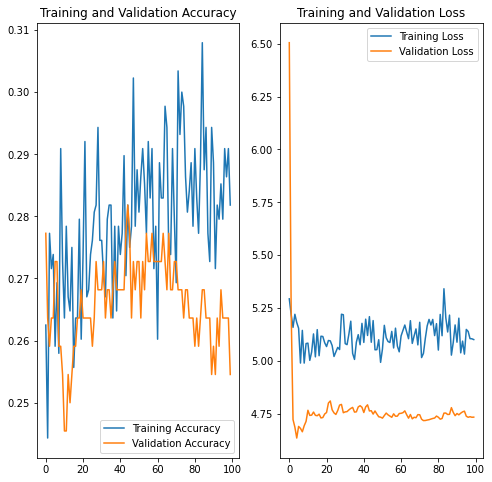

In [79]:
import matplotlib.pyplot as plt

acc = history.history['auxiliary_classifier_acc']
val_acc = history.history['val_auxiliary_classifier_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:
model.save('./models/ResNet50.h5')
# github 문제로 D드라이브에 저장했음

In [70]:
k = model.predict(img_arr[60:63])

In [67]:
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.4f}".format(x)})



In [71]:
k 

[array([[0.0466, 0.0267, 0.0440, 0.3086, 0.0283, 0.0972, 0.0134, 0.1618,
         0.0251, 0.2174, 0.0308],
        [0.0449, 0.0308, 0.0357, 0.2860, 0.0274, 0.1034, 0.0141, 0.1750,
         0.0258, 0.2154, 0.0413],
        [0.0492, 0.0304, 0.0321, 0.2647, 0.0310, 0.1036, 0.0164, 0.2179,
         0.0221, 0.1887, 0.0439]], dtype=float32),
 array([[0.3495, 0.5718, 0.5599, 0.8263, 0.5212, 0.7638, 0.5412, 0.7715,
         0.3580, 0.7143, 0.4075],
        [0.3888, 0.4087, 0.5683, 0.8769, 0.6184, 0.7793, 0.5115, 0.7608,
         0.4115, 0.7373, 0.3887],
        [0.2185, 0.4868, 0.4475, 0.8037, 0.5704, 0.7375, 0.4831, 0.8000,
         0.4251, 0.7515, 0.4562]], dtype=float32)]

In [72]:
y_out[60:63]

array([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000],
       [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000]])

In [33]:
for genre in y_data.columns:
    print(genre, ': ', len(y_data[y_data[genre] == 1]))

Blues :  531
Electronic :  1579
Folk, World, & Country :  826
Funk&Soul :  3284
Hip Hop :  2152
Jazz :  2753
Latin :  335
Pop :  1984
Reggae :  582
Rock :  3308


In [40]:
test_arr = None
count = 0
for path in img_dataset['path']:
    if count > 7000:
        print(path)
        if test_arr is None:
            test_arr = np.expand_dims(load(d_path + path), axis=0)
        else:
            test_arr = np.append(test_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
    count += 1
    print(count)
    if count > 7020:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [56]:
k = model.predict(test_arr)

for i in k:
    print(i)

[0.0256 0.0748 0.0544 0.3698 0.2776 0.3038 0.0235 0.0749 0.0157 0.3039]
[0.0684 0.0392 0.0898 0.4329 0.2506 0.2046 0.0075 0.1337 0.0421 0.1517]
[0.0363 0.1098 0.0889 0.1962 0.1144 0.2021 0.0164 0.0952 0.0330 0.1636]
[0.0186 0.0317 0.0351 0.3653 0.5007 0.2927 0.0016 0.0303 0.1350 0.0936]
[0.0338 0.0744 0.0469 0.3731 0.1085 0.1841 0.0334 0.1940 0.0323 0.4101]
[0.0731 0.1246 0.1015 0.2920 0.0456 0.2342 0.0196 0.2806 0.0649 0.2849]
[0.1078 0.1835 0.1014 0.3195 0.0452 0.2134 0.0231 0.2323 0.0474 0.1789]
[0.0359 0.0438 0.0283 0.1511 0.1232 0.4129 0.0117 0.0796 0.1211 0.6267]
[0.0391 0.1207 0.0689 0.2107 0.1562 0.1494 0.0128 0.1840 0.0488 0.0948]
[0.0589 0.0470 0.0896 0.2259 0.3394 0.1843 0.0159 0.1257 0.0262 0.3237]
[0.0556 0.0571 0.0571 0.3002 0.0848 0.2282 0.0339 0.1216 0.0581 0.1470]
[0.6001 0.0037 0.0000 0.0322 0.1213 0.3494 0.0000 0.0000 0.1238 1.0000]
[0.0392 0.0722 0.1352 0.1191 0.0786 0.3406 0.0280 0.0890 0.0524 0.3587]
[0.0245 0.1675 0.0170 0.1688 0.1321 0.2185 0.0068 0.1412 0.0430 

In [49]:
test_out = np.array(y_data)
test_out = test_out[7001:7021]

In [ ]:
test_out

In [ ]:
for i in range(20):
    print(k[i])
    print(test_out[i])

In [ ]:
img_dataset.iloc[7001:7021,:]

-----

In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                              include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

In [10]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [27]:
from tensorflow.keras.optimizers import RMSprop
from bpmll import bp_mll_loss
import tensorflow_addons as tfa

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(11, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['Precision', 'Recall'])

c:\Users\cid2r\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [28]:
# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [29]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, y_train, 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/100
28/28 [==============================] - 4s 70ms/step - loss: 1.9227 - precision: 0.2035 - recall: 0.1912 - val_loss: 0.7049 - val_precision: 0.0905 - val_recall: 0.1286 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 1s 38ms/step - loss: 0.6767 - precision: 0.2337 - recall: 0.1532 - val_loss: 0.5517 - val_precision: 0.3571 - val_recall: 0.2572 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 1s 38ms/step - loss: 0.5197 - precision: 0.2830 - recall: 0.1643 - val_loss: 0.6314 - val_precision: 0.2626 - val_recall: 0.5531 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 1s 38ms/step - loss: 0.5234 - precision: 0.2731 - recall: 0.1659 - val_loss: 0.5209 - val_precision: 0.3653 - val_recall: 0.2572 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 1s 37ms/step - loss: 0.4443 - precision: 0.3359 - recall: 0.1738 - val_loss: 0.4116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 6/100
28/28

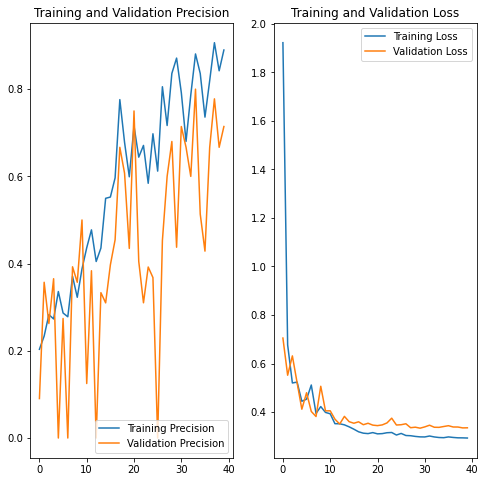

In [32]:
import matplotlib.pyplot as plt

acc = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
model.save('./saved_model/Inception_IMG_binarycross.h5')

-----

In [47]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=12)
fac_input_s = sklearn.utils.shuffle(fac_input, random_state=12)
clr_input_s = sklearn.utils.shuffle(clr_input, random_state=12)
y_out_s = sklearn.utils.shuffle(y_out, random_state=12)

In [48]:
img_arr_test = img_arr_s[1100:]
fac_inp_test = fac_input_s[1100:]
clr_inp_test = clr_input_s[1100:]
y_out_test = y_out_s[1100:]

img_arr_s = img_arr_s[:1100]
fac_input_s = fac_input_s[:1100]
clr_input_s = clr_input_s[:1100]
y_out_s = y_out_s[:1100]

In [41]:
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                              include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [42]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [49]:
from tensorflow.keras.optimizers import RMSprop
from bpmll import bp_mll_loss
import tensorflow_addons as tfa

x = layers.Flatten()(last_output)
real_face_input = tf.keras.layers.Input(shape=(16,))
real_clr_input = tf.keras.layers.Input(shape=(3,))

concat = layers.Concatenate(axis=-1)([x, real_face_input, real_clr_input])

last = layers.Dense(1024, activation='relu')(concat)
last = layers.Dense(11, activation='sigmoid')(last)

model = Model([pre_trained_model.input,real_face_input,real_clr_input], last)
optimizer = tf.keras.optimizers.RMSprop(lr=0.045, epsilon=1.0, decay=0.9)

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['Precision', 'Recall'])

c:\Users\cid2r\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [50]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        [img_arr_s,fac_input_s,clr_input_s], 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_split=0.2, 
        callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)]
    )

Epoch 1/100
28/28 [==============================] - 4s 71ms/step - loss: 2.6353 - precision: 0.1740 - recall: 0.1619 - val_loss: 1.1193 - val_precision: 0.1213 - val_recall: 0.1576 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 1s 39ms/step - loss: 0.8873 - precision: 0.2172 - recall: 0.1896 - val_loss: 0.5243 - val_precision: 0.1364 - val_recall: 0.0675 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 1s 38ms/step - loss: 0.5166 - precision: 0.2831 - recall: 0.1485 - val_loss: 0.4426 - val_precision: 0.3201 - val_recall: 0.2862 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 1s 39ms/step - loss: 0.5005 - precision: 0.2586 - recall: 0.1540 - val_loss: 0.4267 - val_precision: 0.2469 - val_recall: 0.3215 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 1s 39ms/step - loss: 0.5585 - precision: 0.2912 - recall: 0.1840 - val_loss: 0.7337 - val_precision: 0.0877 - val_recall: 0.0482 - lr: 0.0010
Epoch 6/100
28/28 [======

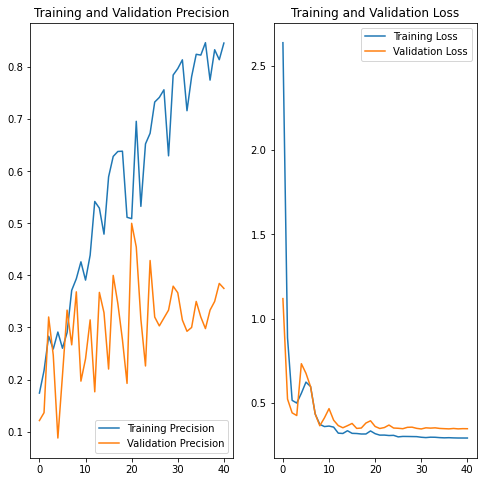

In [51]:
import matplotlib.pyplot as plt

acc = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(41)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Precision')
plt.plot(epochs_range, val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
k = pd.DataFrame(y_train)

In [59]:
for i in range(11):
    print(len(k[k[i]==1]))

37
81
96
341
124
225
45
323
47
211
47


In [67]:
j = k[k[0] != 1]
j = j[j[6] != 1]
j = j[j[8] != 1]
j = j[j[10] != 1]

In [69]:
j

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1094,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1096,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [68]:
for i in range(11):
    print(len(j[j[i]==1]))

0
75
82
300
119
191
0
287
0
181
0
